# DCGAN on Bricks Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb), Lincense: Apache-2.0
- Dataset: [Kaggle](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images)

In [1]:
import numpy as np
import time
from collections import defaultdict
from IPython import display

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import metrics as Metrics

import jax
import jax.numpy as jnp
from functools import partial

import flax.linen as nn
from flax.training import train_state

import optax
from clu import metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 160
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 5e-4

## 1. Prepare dataset

In [3]:
# Convert images to tensors normalize them
def preprocess(img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

# Load lego dataset from directory
def get_dataset():
    train_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='grayscale',
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=None,
        shuffle=True,
        seed=1024,
        interpolation='bilinear',
    ) 

    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds

In [4]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i], cmap='gray')
        ax.axis('off')
    plt.show()

# plot training records
def show_records(history):
    plt.figure(figsize=(12, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

Found 40000 files belonging to 1 classes.
(128, 64, 64, 1)


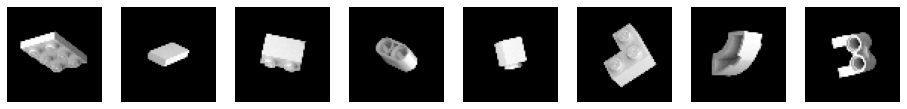

In [5]:
check_ds = get_dataset()
check_sample = next(iter(check_ds))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [6]:
class Discriminator(nn.Module):

    channel_list: tuple = (64, 128, 256, 512)
    
    @nn.compact
    def __call__(self, x, train:bool):

        # Convolutional layers
        for i, features in enumerate(self.channel_list):
            x = self.conv_block(x, features, i, train)

        # Output layers
        x = nn.Conv(features=1, kernel_size=(4, 4), strides=1, 
                    padding='valid', use_bias=False)(x)
        # x = nn.sigmoid(x)
        x = x.reshape(-1, 1)
        return x

    # Downsampling convolution block
    def conv_block(self, x, out_features, use_bn, train:bool):
        x = nn.Conv(features=out_features, kernel_size=(4, 4), strides=2,
                    padding='same', use_bias=False)(x)
        
        if use_bn:
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        return x

net_D = Discriminator()
print(net_D.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 1)), train=False, console_kwargs={'width': 100}))


                                       Discriminator Summary                                        
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module        ┃ inputs         ┃ outputs        ┃ params         ┃ batch_stats     ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│             │ Discriminator │ -              │ float32[1,1]   │                │                 │
│             │               │ float32[1,64,… │                │                │                 │
│             │               │ - train: False │                │                │                 │
├─────────────┼───────────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ Conv_0      │ Conv          │ float32[1,64,… │ float32[1,32,… │ kernel:        │                 │
│             │               │                │                │ float32[4,4,1… │        

In [7]:
class Generator(nn.Module):
    z_dim: int
    channel_list:tuple = (512, 256, 128, 64)

    @nn.compact
    def __call__(self, x, train:bool):
        x = x.reshape(x.shape[0], 1, 1, x.shape[1])

        # Transpose convolution layers
        for i, features in enumerate(self.channel_list):
            strides = 2 if i else 1
            padding = 'SAME' if i else 'VALID'
            x = self.transconv_block(x, features, strides, padding, train)

        # Output layers
        x = nn.ConvTranspose(features=CHANNELS, kernel_size=(4, 4), strides=(2, 2),
                             padding='SAME', use_bias=False)(x)
        x = nn.tanh(x)
        return x

        
    def transconv_block(self, x, out_features, strides, padding:str, train:bool):
        x = nn.ConvTranspose(features=out_features, kernel_size=(4, 4), strides=(strides, strides),
                             padding=padding, use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return x

netG = Generator(Z_DIM)
print(netG.tabulate(jax.random.PRNGKey(0), jnp.ones((1, Z_DIM)), train=False, console_kwargs={'width': 100}))


                                         Generator Summary                                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module        ┃ inputs        ┃ outputs        ┃ params        ┃ batch_stats    ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ Generator     │ -             │ float32[1,64,… │               │                │
│                │               │ float32[1,10… │                │               │                │
│                │               │ - train:      │                │               │                │
│                │               │ False         │                │               │                │
├────────────────┼───────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ ConvTranspose… │ ConvTranspose │ float32[1,1,… │ float32[1,4,4… │ kernel:       │       

## 3. `Train State`

In [8]:
from typing import Any

# adding batch_stats and dropout keys to the properities of the class
class TrainState(train_state.TrainState):
    batch_stats: Any # for batch normalization layers
    key: jax.random.KeyArray = None # for dropout layers


# funtion to create a train state for modules
def create_train_state(module, init_array, 
                       params_key, dropout_key, 
                       learning_rate, train=False):
    """
    module: flax module
    init_array: jax.numpy.ones(shape=module_input_shape)
    param_key, dropout_key: jax.random.PRNGkey(0)
    """

    # Initialize the model with initialization array
    variables = module.init(params_key, init_array, train=train)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Create an optimizer
    tx = optax.adam(learning_rate=learning_rate, b1=ADAM_BETA_1, b2=ADAM_BETA_2)

    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            batch_stats=batch_stats,
            key=dropout_key,
            tx=tx
            )

## 4. Loss functions

NOTE: the first argument of loss function in JAX should be the parameters that needed to be updated \
check here: https://github.com/google/flax/discussions/2420

In [9]:
# Loss function for generator
def g_loss_fn(g_state_params, d_state, real_imgs, rng):
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    
    # generate fake images
    fake_imgs, g_variables = g_state.apply_fn(
                                {'params': g_state_params, 'batch_stats': g_state.batch_stats},
                                latents,
                                train=True,
                                mutable=['batch_stats'])
    
    # get discriminator's preds on fake images
    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    fake_preds, d_variables = d_state.apply_fn(
                                {'params': d_state.params, 'batch_stats': d_state.batch_stats},
                                fake_imgs,
                                train=True,
                                rngs={'dropout': dropout_train_key},
                                mutable=['batch_stats'])

    real_labels = jnp.ones(shape=(BATCH_SIZE,))
    # get generator's loss
    g_loss = optax.sigmoid_binary_cross_entropy(fake_preds.reshape(-1, ), real_labels).mean()
    return g_loss, (g_variables, d_variables)


# Loss function for discriminator
def d_loss_fn(d_state_params, g_state, real_imgs, rng):
    
    # generate fake images
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    fake_imgs, g_variables = g_state.apply_fn(
                            {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                            latents,
                            train=True,
                            mutable=['batch_stats'])

    # get discriminator's preds on real images
    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    real_preds, d_variables = d_state.apply_fn(
                            {'params': d_state_params, 'batch_stats': d_state.batch_stats},
                            real_imgs,
                            train=True,
                            rngs={'dropout': dropout_train_key},
                            mutable=['batch_stats'],)

    # get discriminator's preds on fake images
    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    fake_preds, d_variables = d_state.apply_fn(
                            {'params': d_state_params, 'batch_stats': d_state.batch_stats},
                            fake_imgs,
                            train=True,
                            rngs={'dropout': dropout_train_key},
                            mutable=['batch_stats'],)

    # create real and fake labels
    key_1, key_2 = jax.random.split(rng)
    real_labels = jnp.ones_like(real_preds)
    real_labels_noisy = real_labels + NOISE_PARAM * jax.random.normal(key_1, shape=real_labels.shape)
    fake_labels = jnp.zeros_like(fake_preds)
    fake_labels_noisy = fake_labels - NOISE_PARAM * jax.random.normal(key_2, shape=fake_labels.shape)

    # Compute losses
    real_loss = optax.sigmoid_binary_cross_entropy(real_preds.reshape(-1,), real_labels_noisy.reshape(-1,))
    fake_loss = optax.sigmoid_binary_cross_entropy(fake_preds.reshape(-1,), fake_labels_noisy.reshape(-1,))
    loss = (real_loss + fake_loss).mean()
    return loss, (g_variables, d_variables)

## 5. Train step function

In [10]:
@jax.jit
def train_step(rng, g_state, d_state, real_imgs):
    rng, rng_g, rng_d = jax.random.split(rng, num=3)

    # create gradient functions
    d_grad_fn = jax.value_and_grad(d_loss_fn, has_aux=True, allow_int=True)
    g_grad_fn = jax.value_and_grad(g_loss_fn, has_aux=True, allow_int=True)

    # update discriminator
    (d_loss, (g_variables, d_variables)), d_grads = d_grad_fn(d_state.params, g_state, real_imgs, rng_d)
    d_state = d_state.apply_gradients(grads=d_grads)
    d_state = d_state.replace(batch_stats=d_variables['batch_stats'])
    
    # update generator
    (g_loss, (g_variables, d_variables)), g_grads = g_grad_fn(g_state.params, d_state, real_imgs, rng_g)
    g_state = g_state.apply_gradients(grads=g_grads)
    g_state = g_state.replace(batch_stats=g_variables['batch_stats'])

    return rng, g_state, d_state, g_loss, d_loss

## 6. Load datasets and create `train_stat`s

In [11]:
train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
}

train_ds = get_dataset()
num_steps_per_epoch = train_ds.cardinality().numpy() // EPOCHS

# tf.random.set_seed(10)

rng = jax.random.PRNGKey(0)
d_param_key, g_param_key, dropout_key, rng = jax.random.split(key=rng, num=4)

# create networks
g_net = Generator(Z_DIM)
d_net = Discriminator()

# initialize networks train stats
g_state = create_train_state(g_net, jnp.ones(shape=(1, Z_DIM)), g_param_key, None, learning_rate=LR)
d_state = create_train_state(d_net, jnp.ones(shape=(1, 64, 64, 1)), d_param_key, dropout_key, learning_rate=LR)

Found 40000 files belonging to 1 classes.


Epoch: 160	epoch time 0.17 min
	 d_loss: 0.1205 | g_loss: 5.5600 | 


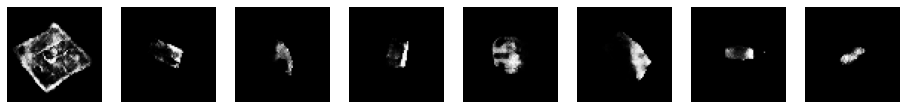

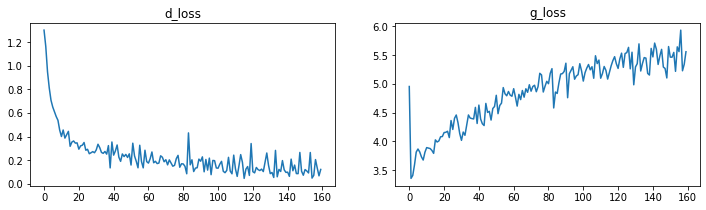

In [12]:
history = defaultdict(list)
prev_time = time.time()

for step, real_imgs in enumerate(train_ds.as_numpy_iterator()):
    # train models    
    rng, g_state, d_state, g_loss, d_loss = train_step(rng, g_state, d_state, real_imgs)  
    train_metrics['d_loss'].update_state(d_loss)
    train_metrics['g_loss'].update_state(g_loss)

    # compute and visualize train metrics at the end of every epoch
    if (step + 1) % num_steps_per_epoch == 0:
        history['d_loss'].append(train_metrics['d_loss'].result().numpy())
        history['g_loss'].append(train_metrics['g_loss'].result().numpy())

        # generate fake images
        latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
        fake_imgs = g_state.apply_fn(
                                    {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                                    latents, train=False)

        display.clear_output(wait=True)
        
        curr_time = time.time()
        curr_epoch = (step + 1) // num_steps_per_epoch
        print('Epoch: {}\tepoch time {:.2f} min'.format(curr_epoch, (curr_time - prev_time) / 60))
        metrics = [f'{key}: {value.result().numpy():.4f} | ' for key, value in train_metrics.items()]
        print('\t', ''.join(metrics))
        
        display_imgs(fake_imgs)
        show_records(history)

        # reset metrics
        train_metrics['d_loss'].reset_state()
        train_metrics['g_loss'].reset_state()
        prev_time = curr_time

## 7. Generate new images

In [13]:
# sample latent vector for normal distribution
grid_width, grid_height = (10, 3)
rng = jax.random.PRNGKey(0)
latents = jax.random.normal(rng, shape=(grid_width * grid_height, Z_DIM))
generated_imgs = g_state.apply_fn(
                            {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                            latents,
                            train=False)

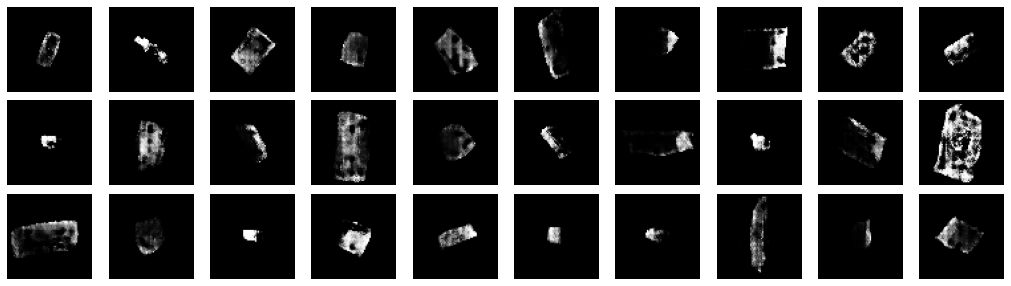

In [14]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i], cmap="gray")

## 8. Output matching

In [15]:
all_imgs = None
for i, imgs in enumerate(train_ds.as_numpy_iterator()):
    if i == 0: all_imgs = imgs
    else: 
        all_imgs = np.concatenate([all_imgs, imgs], axis=0)
        if (i + 1) % num_steps_per_epoch == 0: break

print(all_imgs.shape)

(39936, 64, 64, 1)


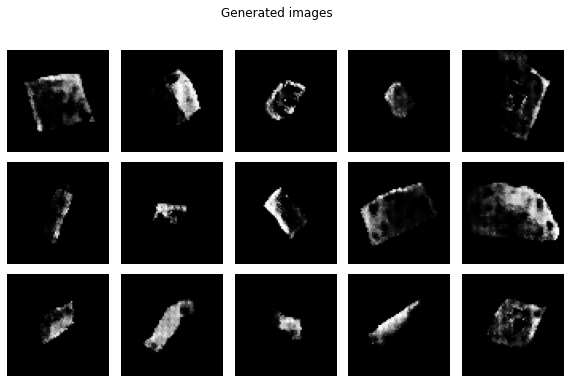

In [16]:
grid_width, grid_height = (5, 3)
rng = jax.random.PRNGKey(0)
latents = jax.random.normal(rng, shape=(grid_width * grid_height, Z_DIM))
generated_imgs = g_state.apply_fn(
                            {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                            latents,
                            train=False)

generated_imgs = np.asarray(generated_imgs) # convert jax array to np array

# Draw a plot of decoded images
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Generated images')

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i], cmap="gray")

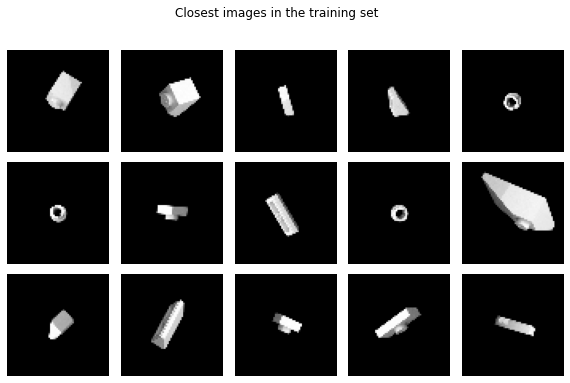

In [17]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Closest images in the training set')

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    # Compare images
    gen_img = generated_imgs[i].reshape(1, *generated_imgs[0].shape)
    L1_dist = np.abs(all_imgs - gen_img).reshape(len(all_imgs), -1).mean(axis=1)
    selection = L1_dist.argmin()

    ax.imshow(all_imgs[selection], cmap="gray")